Important Disclaimers
=====================

The analysis presented below is intended for **teaching purposes only**. That is, it has not been vetted for statistical significance, market effectiveness, trading costs, predictive accuracy, or any other validation of the parameters and models selected. We highly recommend that you **do not trade based on this model**, as that is not the intent of this seminar.

Further, the views in this document do not represent those of the presenters Sandeep Balasubramanian and Robert Ying, nor those of the Application Development Initiatve, the Columbia Data Science Society, AQR Capital, or D.E. Shaw & Co.

That said, we hope you learn something about applied data science and timeseries forecasting!

Setup:
------

In [1]:
import pandas as pd
import numpy as np
from pandas.tools.plotting import autocorrelation_plot
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

plt.rcParams['figure.figsize'] = (10, 6)
%matplotlib inline

# Forecasting with Time Series Data

## Introduction to Time Series Data ##

Much of the data we interact with on a daily basis are drawn from time series. What's the temperature outside today? Is my diet working? How's the stock market doing? A **time series** is a set of observations of a single variable at multiple different points in time. Time series data differs from other data because these observations aren't usually independent from each other. For example, the stock price of Microsoft today is very related to the MSFT price yesterday. In contrast, if you were to sample people in this room to look for a relationship between height and GPA, you could be reasonably confident that each observation $(height, gpa)$ is independent from each other. 

## Modelling a Time Series##


### Stationarity ###

A process (from which a time series is sampled) is said to be **stationary** if the distribution of the observed values does not depend on time. One example of a nonstationary process is a stock price -- over the decades there's certainly been an upward trend, so the average price of IBM in 1995 is different than the average price of IBM in 2015. What we want is the distribution of the observed variable to be independent of time. We'd like for the mean and our variance of our observations to be constant over time. 

Taking the trends out of data to make it stationary allows us to properly run regressions against other variables (otherwise we risk spurious results that conflate the time trend with the effect of the other variables). We can make data stationary by taking differences of of the observations. For example, below we have a graph of drug sales. There is clearly a trend over time--by looking at the *difference* in sales instead of the sales numbers themselves, we can more accurately find the relationships between it and a proposed explanatory variable. 

<img src="https://www.otexts.org/sites/default/files/fpp/images/diffa10.png" width="600"/>

A process that becomes stationary after differencing *d* times is said to be **integrated with order d**.

### Autoregressive Model ###

In an **autoregressive model**, the response variable is regressed against previous values from the same time series. For example, we might think that the price of MSFT today is some linear combination of prices of MSFT over the last few days: 

$ \begin{equation*}  price_{t}=\beta_{0}+\beta_{1}price_{t-1}+\beta_{2}price_{t-2}+\beta_{3}price_{t-3}+\epsilon_{t}.  \end{equation*} $

We say that a process if **AR(1)** if only the previous observed value is used. A process that uses the previous *p* values is called **AR(p)**. A classic example of an AR(1) process is a **random walk**. In a random walk, a "walker" has an equal chance of stepping left or stepping right. At each time observation, the walker randomly takes a step. The position of this walker over time is therefore a direct function of where they were at the previous time and the random step direction.

<center> **a single random walker** </center>
<img src="http://people.duke.edu/~rnau/411rand_files/image004.jpg" />

<center> **various possible random walks** </center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/da/Random_Walk_example.svg/720px-Random_Walk_example.svg.png">

### Moving Average Model ###

A **moving average model** is similar to an autoregressive model except that instead of being based on the previous observed values $y_t$, the model describes a relationship between an observation and the previous error terms. We say that a process if **MA(1)** if only the previous observed value is used. A process that uses the previous *p* values is called **MA(p)**. 

<img src="https://upload.wikimedia.org/math/9/5/a/95a85ea60c0cd898823ffe17fb509475.png" />

As an example, imagine looking at time series data around Moore's law. "Moore's law" is the observation that, over the history of computing hardware, the number of transistors in a dense integrated circuit has doubled approximately every two years. 

<img src="http://www.overclock.net/image/id/10100141" width="600"/>

Notice that the y axis has a log scale. The trend here appears linear after taking the log. Is our transistor count stationary? Not yet! However, if we difference the data once, now we're talking about the slope -- purely by inspection, the slope looks like it's pretty constant through time. Therefore we could guess that the change in log transistor count is stationary over time. We might consider using an MA(1) process to model this. This would suggest that if the change in log transistor count is lower by 2% in period 1, that error would adjust the forecast of period 2. 


## Analysis ##

### Our Dataset ###

The New York Independent System Operator (NYISO) operates competitive wholesale markets to manage the flow of electricity across New York. We will be using this data, along with weather forecasts, to create a model that predicts electricity prices. 

### Definitions ###

**NYISO**: New York Independent System Operator

**LBMP**: Locational Based Marginal Pricing

**Day Ahead Market**: The Day-Ahead Energy Market lets market participants commit to buy or sell wholesale electricity one day before the operating day, to help avoid price volatility. 

**Realtime Market**: The Real-Time Energy Market lets market participants buy and sell wholesale electricity during the course of the operating day. The Real-Time Energy Market balances the differences between day-ahead commitments and the actual real-time demand for and production of electricity.

**Vintage Date**: The day that the weather is predicted for is the vintage date.

**Forecast Date**: The date on which the above temperature is predicted is the forecast date. 

**Vintage Category**: A prediction is made on several days leading up to the vintage date. Additionally, the temperature on the vintage date is also recorded after the date has passed. To distinguish between these, there are two types of observations: forecasts (the prediction) and actual (the realized temperature, as documented on a later date). 

In [2]:
# load all the data
day_ahead_market = pd.read_csv('datasets/timeseries/day_ahead_market_lbmp.csv.gz')
real_time_market = pd.read_csv('datasets/timeseries/real_time_market_lbmp.csv.gz')
weather_forecast = pd.read_csv('datasets/timeseries/weather_forecast.csv.gz')

In [5]:
day_ahead_market.head()

,Time Stamp,Name,PTID,LBMP ($/MWHr),Marginal Cost Losses ($/MWHr),Marginal Cost Congestion ($/MWH
0,01/01/2015 00:00,CAPITL,61757,33.45,1.13,-11.71
1,01/01/2015 00:00,CENTRL,61754,21.89,-0.12,-1.41
2,01/01/2015 00:00,DUNWOD,61760,31.27,1.79,-8.88
3,01/01/2015 00:00,GENESE,61753,20.84,-0.86,-1.11
4,01/01/2015 00:00,H Q,61844,20.25,-0.35,0.00


In [6]:
real_time_market.head()

,Time Stamp,Name,PTID,LBMP ($/MWHr),Marginal Cost Losses ($/MWHr),Marginal Cost Congestion ($/MWHr)
0,01/01/2015 00:05:00,CAPITL,61757,32.51,1.53,-9.07
1,01/01/2015 00:05:00,CENTRL,61754,22.84,-0.15,-1.09
2,01/01/2015 00:05:00,DUNWOD,61760,30.72,1.95,-6.87
3,01/01/2015 00:05:00,GENESE,61753,21.65,-1.12,-0.86
4,01/01/2015 00:05:00,H Q,61844,21.53,-0.37,0.00


In [7]:
# convert string date column to datetime type
day_ahead_market['Time Stamp'] = pd.to_datetime(day_ahead_market['Time Stamp'], format='%m/%d/%Y %H:%M')
real_time_market['Time Stamp'] = pd.to_datetime(real_time_market['Time Stamp'], format='%m/%d/%Y %H:%M:%S')

In [8]:
# convert dates to datetimes on the weather data
weather_forecast['Forecast Date'] = pd.to_datetime(weather_forecast['Forecast Date'], format='%m/%d/%Y')
weather_forecast['Vintage Date'] = pd.to_datetime(weather_forecast['Vintage Date'], format='%m/%d/%Y')
weather_forecast['Vintage'] = weather_forecast['Vintage'].astype('category')

weather_forecast.head()

,Forecast Date,Vintage Date,Vintage,Station ID,Max Temp,Min Temp,Max Wet Bulb,Min Wet Bulb
0,2015-01-01,2015-01-01,Forecast,ALB,31,18,23,15
1,2015-01-01,2015-01-01,Forecast,ART,32,24,28,21
2,2015-01-01,2015-01-01,Forecast,BGM,27,15,21,12
3,2015-01-01,2015-01-01,Forecast,BUF,30,21,26,18
4,2015-01-01,2015-01-01,Forecast,ELM,32,16,24,13


In [9]:
# re-index the data by name of region and timestamp. This helps us manipulate and access the data. 
dam_time_name = day_ahead_market.set_index(['Name', 'Time Stamp'])
rtm_time_name = real_time_market.set_index(['Name', 'Time Stamp'])

dam_time_name.head()

,,PTID,LBMP ($/MWHr),Marginal Cost Losses ($/MWHr),Marginal Cost Congestion ($/MWH
Name,Time Stamp,,,,
CAPITL,2015-01-01,61757,33.45,1.13,-11.71
CENTRL,2015-01-01,61754,21.89,-0.12,-1.41
DUNWOD,2015-01-01,61760,31.27,1.79,-8.88
GENESE,2015-01-01,61753,20.84,-0.86,-1.11
H Q,2015-01-01,61844,20.25,-0.35,0.00


In [10]:
# select just the NYC data
dam_nyc_lbmp = dam_time_name['LBMP ($/MWHr)']['N.Y.C.']
rtm_nyc_lbmp = rtm_time_name['LBMP ($/MWHr)']['N.Y.C.']

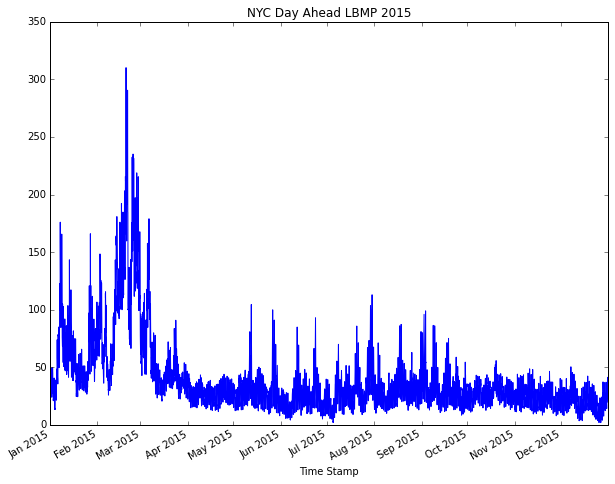

In [11]:
plt.figure(figsize=(10,8))
dam_nyc_lbmp.plot(title='NYC Day Ahead LBMP 2015')

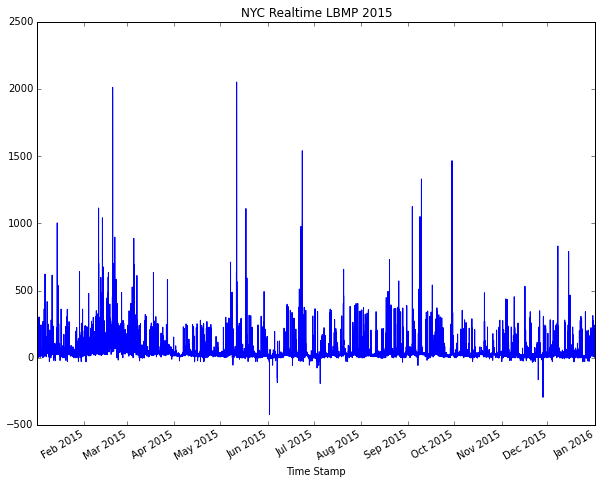

In [12]:
plt.figure(figsize=(10,8))
rtm_nyc_lbmp.plot(title='NYC Realtime LBMP 2015')

In [13]:
# Real Time Data Peek
rtm_nyc_lbmp.head()

Time Stamp
2015-01-01 00:05:00    30.79
2015-01-01 00:10:00    30.75
2015-01-01 00:15:00    31.32
2015-01-01 00:20:00    30.79
2015-01-01 00:25:00    31.26
Name: LBMP ($/MWHr), dtype: float64

In [14]:
# Day Ahead Data Peek
dam_nyc_lbmp.head()

Time Stamp
2015-01-01 00:00:00    31.45
2015-01-01 01:00:00    26.49
2015-01-01 02:00:00    24.54
2015-01-01 03:00:00    23.64
2015-01-01 04:00:00    24.10
Name: LBMP ($/MWHr), dtype: float64

Now there's a slight problem--the timestamps on the realtime data and day ahead data don't actually line up. More specifically, the realtime data has observations every 5 minutes while the day ahead data has observations every hour. To fix this, we need to align the two series of data. 

In [15]:
aligned_dam, aligned_rtm = rtm_nyc_lbmp.align(dam_nyc_lbmp, join='inner')

In [16]:
# Remove Duplicates

no_dup_al_dam = aligned_dam[~aligned_dam.index.duplicated(keep='first')]
no_dup_al_rtm = aligned_rtm[~aligned_dam.index.duplicated(keep='first')]

no_dup_al_dam.name = 'dam_lbmp'
no_dup_al_rtm.name = 'rtm_lbmp'

Next step is to wrap this up nicely in a data frame. However, just constructing the data frame the default way will give us a very *wide* dataframe-- to make it into a *tall* one we'll need to transpose. 

In [17]:
# this dataframe is too wide
pd.DataFrame([no_dup_al_dam, no_dup_al_rtm])

Time Stamp,2015-01-01 01:00:00,2015-01-01 02:00:00,2015-01-01 03:00:00,2015-01-01 04:00:00,2015-01-01 05:00:00,2015-01-01 06:00:00,2015-01-01 07:00:00,2015-01-01 08:00:00,2015-01-01 09:00:00,2015-01-01 10:00:00,...,2015-12-31 14:00:00,2015-12-31 15:00:00,2015-12-31 16:00:00,2015-12-31 17:00:00,2015-12-31 18:00:00,2015-12-31 19:00:00,2015-12-31 20:00:00,2015-12-31 21:00:00,2015-12-31 22:00:00,2015-12-31 23:00:00
dam_lbmp,32.94,62.32,37.20,29.75,44.51,25.81,28.04,22.07,17.94,9.05,...,22.00,20.41,14.56,19.25,27.65,57.16,17.77,22.02,14.00,16.14
rtm_lbmp,26.49,24.54,23.64,24.10,26.32,31.48,30.57,31.34,33.21,29.85,...,24.88,25.54,31.94,41.37,32.24,30.76,27.99,24.12,22.61,19.84


In [18]:
# transpose dataframe to make it tall
dam_rtm_df = pd.DataFrame([no_dup_al_dam, no_dup_al_rtm]).transpose()
dam_rtm_df.head()

,dam_lbmp,rtm_lbmp
Time Stamp,,
2015-01-01 01:00:00,32.94,26.49
2015-01-01 02:00:00,62.32,24.54
2015-01-01 03:00:00,37.20,23.64
2015-01-01 04:00:00,29.75,24.10
2015-01-01 05:00:00,44.51,26.32


Now that we have our pricing data for the NYC region, we need to get the weather data ready. The weather data comes from a different data source, and unfortunately it's not split into the same exact regions as the pricing data. To remedy this, we'll pick two weather stations nearby -- the ones located at JFK airport and LGA airport -- and average the temperatures together. 

In [19]:
# a reminder about what the weather data looks like
weather_forecast.head()

,Forecast Date,Vintage Date,Vintage,Station ID,Max Temp,Min Temp,Max Wet Bulb,Min Wet Bulb
0,2015-01-01,2015-01-01,Forecast,ALB,31,18,23,15
1,2015-01-01,2015-01-01,Forecast,ART,32,24,28,21
2,2015-01-01,2015-01-01,Forecast,BGM,27,15,21,12
3,2015-01-01,2015-01-01,Forecast,BUF,30,21,26,18
4,2015-01-01,2015-01-01,Forecast,ELM,32,16,24,13


In [21]:
# get every temperature from the LGA and JFK stations
lga_and_jfk_indexed = weather_forecast[(weather_forecast['Station ID'] == 'LGA') |
                                       (weather_forecast['Station ID'] == 'JFK')].set_index(['Forecast Date',
                                                                                             'Vintage Date',
                                                                                             'Vintage',
                                                                                             'Station ID'])
lga_and_jfk_indexed.head()

Max Temp  Min Temp  \
Forecast Date Vintage Date Vintage  Station ID                       
2015-01-01    2015-01-01   Forecast JFK               39        27   
                                    LGA               37        26   
              2015-01-02   Forecast JFK               42        31   
                                    LGA               41        32   
              2014-12-29   Actual   JFK               46        36   

                                                Max Wet Bulb  Min Wet Bulb  
Forecast Date Vintage Date Vintage  Station ID                              
2015-01-01    2015-01-01   Forecast JFK                   31            22  
                                    LGA                   29            21  
              2015-01-02   Forecast JFK                   34            27  
                                    LGA                   32            27  
              2014-12-29   Actual   JFK                   37            30

In [22]:
# average together LGA and JFK temperatures (you'll notice that it's no longer in our data!)
mean_nyc_indexed = lga_and_jfk_indexed.mean(level=[0,1,2])
mean_nyc_indexed.head()

Max Temp  Min Temp  Max Wet Bulb  \
Forecast Date Vintage Date Vintage                                      
2015-01-01    2014-12-29   Actual        44.5      36.0          36.5   
              2014-12-30   Actual        35.5      28.5          30.0   
              2014-12-31   Actual        32.5      27.5          25.5   
              2015-01-01   Forecast      38.0      26.5          30.0   
              2015-01-02   Forecast      41.5      31.5          33.0   

                                     Min Wet Bulb  
Forecast Date Vintage Date Vintage                 
2015-01-01    2014-12-29   Actual            30.0  
              2014-12-30   Actual            23.0  
              2014-12-31   Actual            22.5  
              2015-01-01   Forecast          21.5  
              2015-01-02   Forecast          27.0

We need to massage our data a bit more. First step is to unindex, which flattens our dataframe. Next, we pick out only the rows with the Vintage being 'Actual'. We've got a few different kinds of dates floating around and it's important to stay consistent. Our end goal is to have our data like:

**Time stamp**:        today 

**Temperature**:       the actual temperature today **(x)**

**Day ahead price**:   today's price for electricity tomorrow **(x)**

**Realtime price**:    tomorrrow's electricity price observed tomorrow **(y)**

In [23]:
mean_nyc = mean_nyc_indexed.reset_index()
actual_temp_df = mean_nyc[mean_nyc['Vintage'] == 'Actual'] \
    .groupby(['Vintage Date']).first() \
    .rename(columns=lambda x: 'Actual ' + x) # prepend the word Actual to column names

dam_rtm_act_df = dam_rtm_df.join(actual_temp_df, how='left').fillna(method='ffill').dropna()

dam_rtm_act_df.head()

,dam_lbmp,rtm_lbmp,Actual Forecast Date,Actual Vintage,Actual Max Temp,Actual Min Temp,Actual Max Wet Bulb,Actual Min Wet Bulb
Time Stamp,,,,,,,,
2015-01-02 00:00:00,16.87,28.77,2015-01-03,Actual,43,35.5,33.5,30
2015-01-02 01:00:00,26.47,27.61,2015-01-03,Actual,43,35.5,33.5,30
2015-01-02 02:00:00,15.07,24.41,2015-01-03,Actual,43,35.5,33.5,30
2015-01-02 03:00:00,14.24,24.01,2015-01-03,Actual,43,35.5,33.5,30
2015-01-02 04:00:00,12.95,24.03,2015-01-03,Actual,43,35.5,33.5,30


Next, observe that there is a different day ahead price every single hour, but only a single temperature estimate per day. We'll do something similar to the frequency mismatch we saw with day ahead/realtime data -- resample at the lower frequency and average the data in those lower frequency buckets.

In [24]:
# Resample to daily because temperature and prices don't have the same frequency
daily_df = dam_rtm_act_df.resample('D', how='mean')
daily_df.head()

,dam_lbmp,rtm_lbmp,Actual Max Temp,Actual Min Temp,Actual Max Wet Bulb,Actual Min Wet Bulb
Time Stamp,,,,,,
2015-01-02,47.749583,32.220833,43.0,35.5,33.5,30.0
2015-01-03,33.246667,27.447917,43.0,31.0,42.5,27.5
2015-01-04,29.820417,23.439583,55.0,42.0,53.0,41.0
2015-01-05,66.288333,42.450000,51.0,22.5,43.0,17.5
2015-01-06,64.860833,60.502917,22.5,19.0,20.0,15.0


The next question is whether to use the max temp or min temp--let's take a look at the data to see if one or the other makes a difference.

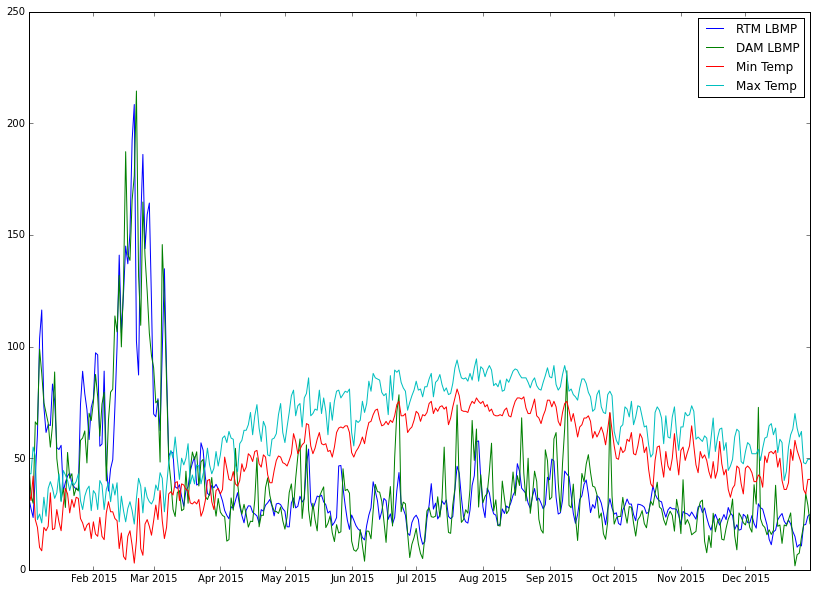

In [26]:
plt.figure(figsize=(14,10))
plt.plot_date(daily_df.index, daily_df['rtm_lbmp'], '-', label='RTM LBMP')
plt.plot_date(daily_df.index, daily_df['dam_lbmp'], '-', label='DAM LBMP')
plt.plot_date(daily_df.index, daily_df['Actual Min Temp'], '-', label='Min Temp')
plt.plot_date(daily_df.index, daily_df['Actual Max Temp'], '-', label='Max Temp')
plt.legend()

Min and max temperature seem to be so highly correlated with each other that it most likely won't matter one way or another which we used.

### Model Estimation ##

Now that our data is in the format we want, we can finally put into practice some of those theoretical concepts we discussed at the beginning. Our tool of choice here is a type of regression called **ARIMA**. It's a combination of 3 types of models -- AutoRegressive (a combination of the previous values), Integrated (differencing the data), Moving Average (smoothing the data). It's typically represented as: 

arima(# of AR terms, # of differences, # of smoothing terms) = $ arima(p,d,q) $.

So how can we go about picking our parameters p, i, and q? There's several approaches of varying sophistication.  A common approach is to use the <a href="https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins#Identify_p_and_q"> Box-Jenkins Method </a> for parameter selection. First, you pick parameter d (does the data need differencing to make it stationary?) You can do this using a **Dickey-Fuller test**. Then, you can use autocorrelation function (ACF) and partial autocorrelation function (PACF) to identify the AR parameter (p) and the MA parameter (q). 

For our example, we'll just pick ARIMA(0,0,1) for it's simplicity (this is therefore just an MA(1) process). At the end we discuss these tools / the procedure in more detail.

Before fitting the model, we'll be splitting our data into two chunks -- one to train the model on and one to test it. This gives us a chance to see how the model would do in the "real world" on data it hasn't seen before.

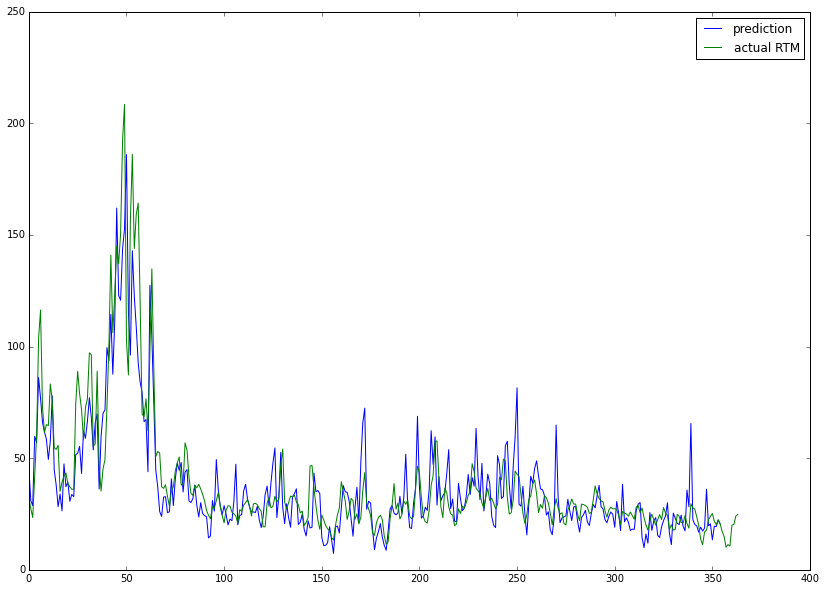

In [27]:
exog_data = np.array([daily_df['Actual Max Temp'].values, daily_df['dam_lbmp'].values])

# fit the model on a portion of the data
k = 250
m = ARIMA(daily_df['rtm_lbmp'].values[0:k], [0,0,1], exog=np.transpose(exog_data[:,0:k]), dates=daily_df.index.values[0:k])
results = m.fit(trend='nc', disp=True)

# what does our model predict?
predicted_prices = results.predict(10, 364, exog=np.transpose(exog_data), dynamic=True)

# let's see it graphically
plt.figure(figsize=(14, 10))
plt.plot(predicted_prices, label='prediction')
plt.plot(daily_df['rtm_lbmp'].values, label='actual RTM')
#plt.plot(daily_df['dam_lbmp'].values, label='actual DAM')

plt.legend()

In [28]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  250
Model:                     ARMA(0, 1)   Log Likelihood               -1029.430
Method:                       css-mle   S.D. of innovations             14.855
Date:                Mon, 29 Feb 2016   AIC                           2066.860
Time:                        17:07:58   BIC                           2080.946
Sample:                    01-02-2015   HQIC                          2072.529
                         - 09-08-2015                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.0571      0.027      2.126      0.035         0.004     0.110
x2             0.8586      0.033     25.844      0.000         0.793     0.924
ma.L1.y        0.4423      0.061      7.239      0.000         0.323     0.562
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -2.2608           +0.0000j            2.2608            0.5000
-----------------------------------------------------------------------------
"""

## Analysis ##

Our model seems to work well from the graph of the the forecast. Looking at the coefficients from the ARIMA model, we can see that that increasing temperatures and increasing day ahead prices are both associated with higher realtime prices the next day. Just by looking at the coefficients, one can see that our forecast is extremely similar to the day ahead values, with a small adjustment based on temperature and another adjustment based on the moving average term.  

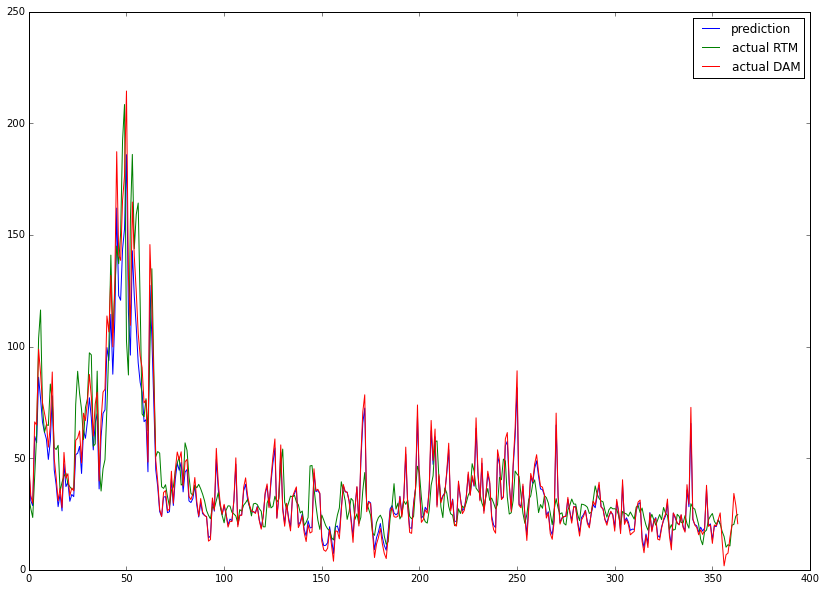

In [29]:
plt.figure(figsize=(14, 10))
plt.plot(predicted_prices, label='prediction')
plt.plot(daily_df['rtm_lbmp'].values, label='actual RTM')
plt.plot(daily_df['dam_lbmp'].values, label='actual DAM')

plt.legend()

## How Did We Do? ##

Our data and model helps us predict the realtime electricity cost the day before. If you ran a company with significant power demands, you might be able to use such a model to decide whether or not to buy electricity in advance or on demand. Let's see how it would work!

1. Learn about Autoregressive Integrated Moving Average models
2. Apply it to a relevant dataset
3. ????
4. PROFIT!!!

In [30]:
# Profit Check
len(predicted_prices)
len(daily_df['rtm_lbmp'].values[10:])

print("--- Trading Log ---")

i = 251
PnL = np.zeros(100)


while i < 351:
    if (predicted_prices[i] < daily_df['dam_lbmp'].values[i]) and (daily_df['rtm_lbmp'].values[i+1] < daily_df['dam_lbmp'].values[i]):
        
        # if our model says the DAM is overpriced, then don't pre-buy and buy at the realtime price
        
        print("Buy RTM, +", daily_df['dam_lbmp'].values[i] - daily_df['rtm_lbmp'].values[i+1])
        PnL[i-251] = daily_df['dam_lbmp'].values[i] - daily_df['rtm_lbmp'].values[i+1]
        
    elif (predicted_prices[i] > daily_df['dam_lbmp'].values[i]) and (daily_df['rtm_lbmp'].values[i+1] > daily_df['dam_lbmp'].values[i]):
        
        # if our model says the DAM is underpriced, pre-buy the electricity so you don't have to pay realtime price 
        
        print("Buy DAM, +", daily_df['rtm_lbmp'].values[i+1] - daily_df['dam_lbmp'].values[i] )
        PnL[i-251] = daily_df['rtm_lbmp'].values[i+1] - daily_df['dam_lbmp'].values[i]
        
    else:
        
        # if we were wrong, we lose money :(
        
        print("Lose $$, -", max(daily_df['rtm_lbmp'].values[i+1] - daily_df['dam_lbmp'].values[i],daily_df['dam_lbmp'].values[i] - daily_df['rtm_lbmp'].values[i+1]))
        PnL[i-251] = min(daily_df['rtm_lbmp'].values[i+1] - daily_df['dam_lbmp'].values[i],daily_df['dam_lbmp'].values[i] - daily_df['rtm_lbmp'].values[i+1])
    i = i+1
    

--- Trading Log ---
('Buy DAM, +', 4.7812499999999964)
('Lose $$, -', 2.4829166666666715)
('Buy RTM, +', 17.576249999999991)
('Buy DAM, +', 0.96041666666667069)
('Buy DAM, +', 18.397499999999997)
('Buy DAM, +', 4.6199999999999939)
('Buy RTM, +', 4.8508333333333411)
('Lose $$, -', 0.82583333333333542)
('Buy RTM, +', 13.429583333333326)
('Buy RTM, +', 25.946249999999988)
('Buy RTM, +', 14.424166666666668)
('Buy RTM, +', 9.9324999999999974)
('Buy RTM, +', 3.8166666666666558)
('Buy RTM, +', 1.2629166666666691)
('Buy DAM, +', 6.7224999999999966)
('Lose $$, -', 0.052083333333332149)
('Buy DAM, +', 4.0216666666666612)
('Buy DAM, +', 13.397499999999994)
('Buy DAM, +', 10.117500000000003)
('Buy RTM, +', 42.542500000000004)
('Buy RTM, +', 8.0600000000000058)
('Buy DAM, +', 5.0695833333333304)
('Lose $$, -', 2.4054166666666674)
('Buy RTM, +', 3.8545833333333306)
('Buy DAM, +', 2.8687499999999986)
('Buy RTM, +', 3.5899999999999999)
('Buy DAM, +', 5.9754166666666606)
('Buy DAM, +', 8.53541666666666

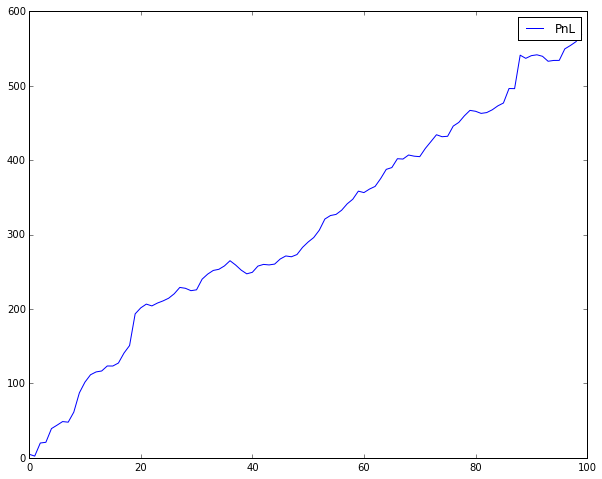

In [31]:
cumPnL = np.cumsum(PnL)
plt.figure(figsize=(10, 8))
plt.plot(cumPnL, label='PnL')
plt.legend()

It looks like the model works because it predicts every so slightly closer to the true RTM than the DAM!

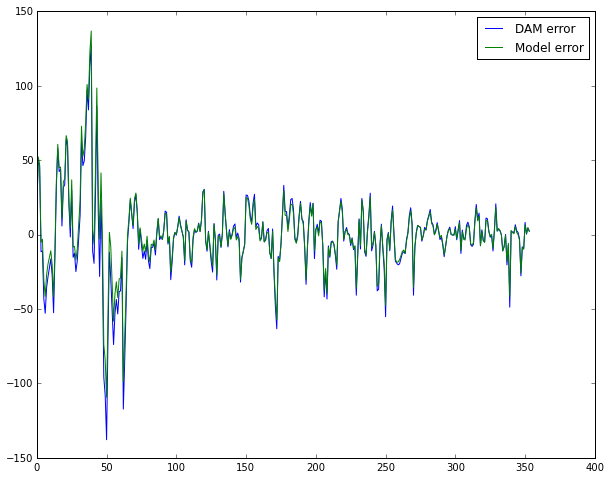

In [32]:
dam_adj = daily_df['rtm_lbmp'].values[10:]-daily_df['dam_lbmp'].values[:-10]
mod_adj = daily_df['rtm_lbmp'].values[10:]-predicted_prices[:-1]
plt.figure(figsize=(10, 8))
plt.plot(dam_adj, label='DAM error')
plt.plot(mod_adj, label='Model error')
plt.legend()

# Problems #

There are MANY potential problems with this approach that need to be mentioned. Though the results seem okay, this is a good example of a model that might fit but not be meaningful. 

**Seasonality**: Data with simple trends can be differenced once to achieve stationarity. However, you will often find data that varies by season. In our case, weather data and electricity usage are strong candidates for having some sort of seasonal trend. To deal with this, we would need to grab several years of data and incoporate the yearly differences (between Jan 1 2015 and Jan 1 2016, for example) in addition. Seasonal ARIMA (SARIMA) is a tool for this purpose.

**Parameter Estimation**: It could easily take a whole workshop to discuss choosing model form. The parameters chosen ARIMA(0,0,1) may be inappropriate. When doing ARIMA, we want the y variable (RTM in our case) to be stationary (that is, the distribution doesn't change over time). This assumption of stationary may seem suspect, especially given the winter activity (discussed in *seasonality* section below). You should use of the Dickey Fuller test to make sure stationarity is appropriate. 

Additionally, the AR(p) and MA(q) terms need to be determined by using ACF and PACF. The ACF tells you how much an observation at time i is related to observations at times i-1, i-2, etc. The PACF is similar to an ACF but it controls for the values of the time series at all shorter lags (how much does the 3rd lag tell me beyond what the 1st and 2nd ones do?). See it in action below.

c:\python27\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


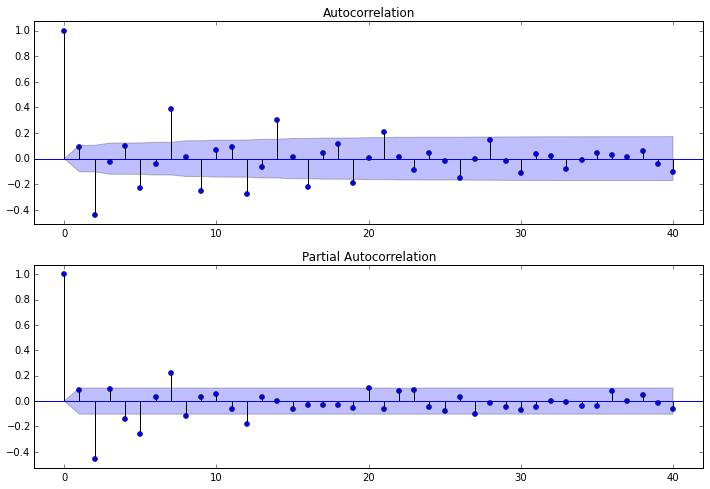

In [33]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(np.diff(daily_df['rtm_lbmp'].values), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(np.diff(daily_df['rtm_lbmp'].values), lags=40, ax=ax2)

Interpreting these plots is a bit of an art as well as a science. There are many different rules that you can use to help you determine the "correct" parameters for an ARIMA process, though it's important to note that there isn't always a right answer; in fact, it's not always possible to model some data using ARIMA. 

<img src="http://www.civildatanalytics.com/uploads/4/6/2/5/46259103/980794_orig.png" />